In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import tqdm
import seaborn as sns
import numpy.testing as np_testing
from sklearn.metrics import precision_recall_curve, roc_curve

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

Ploting functions, nothing to do here...

In [2]:
def plot_level_lines(model, data, labels, size=100):
    def _expand(a, b, frac=.5, margin=1.):
        return a - abs(a) * frac - margin, b + abs(b) * frac + margin

    plt.figure(figsize=(10, 7))
    min_x, min_y = data.min(axis=0)
    max_x, max_y = data.max(axis=0)
    min_x, max_x = _expand(min_x, max_x)
    min_y, max_y = _expand(min_y, max_y)

    all_x = np.linspace(min_x, max_x, num=size)
    all_y = np.linspace(min_y, max_y, num=size)
    XX, YY = np.meshgrid(all_x, all_y)
    test_data = np.c_[XX.ravel(), YY.ravel()]

    try:
        predictions = model.decision_function(test_data).reshape(size, size)
        data_scores = model.predict(data)
        anomaly_scores = model.decision_function(data)
    except AttributeError:
        try:
            predictions = model._decision_function(test_data).reshape(size, size)
            data_scores = model._predict(data)
            anomaly_scores = model._decision_function(data)
        except AttributeError:
            predictions = model.predict_proba(test_data)[:, 0].reshape(size, size)
            data_scores = model.predict(data)
            anomaly_scores = model.predict_proba(data)[:, 0]

    plt.contourf(all_x, all_y, predictions, cmap=plt.cm.coolwarm)

    threshold = anomaly_scores[data_scores==1.0].min()
    plt.contour(XX, YY, predictions, levels=[threshold], linewidths=2, colors='darkred')

    plt.scatter(data[:, 0], data[:, 1], c=labels)

    axes = plt.gca()
    axes.set_xlim([min_x,max_x])
    axes.set_ylim([min_y,max_y])

    plt.show()
    plt.close()
from sklearn.metrics import precision_recall_curve, roc_curve


def plot_results(y_test, probabilities):
    # plot ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    precision, recall, _ = precision_recall_curve(y_test, probabilities)

    fig, (ax_roc, ax_pr_rec) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)

    # roc
    ax_roc.plot(fpr, tpr, linewidth=3)
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')

    ax_roc.grid(True)
    ax_roc.xaxis.label.set_fontsize(20)
    ax_roc.yaxis.label.set_fontsize(20)

    ax_roc.fill_between(fpr, tpr, 0, alpha=0.1)

    # precision-recall
    ax_pr_rec.plot(recall, precision, linewidth=3)
    ax_pr_rec.set_xlabel('Recall')
    ax_pr_rec.set_ylabel('Precision')

    ax_pr_rec.grid(True)
    ax_pr_rec.xaxis.label.set_fontsize(20)
    ax_pr_rec.yaxis.label.set_fontsize(20)

    ax_pr_rec.fill_between(recall, precision, 0, alpha=0.1)

    plt.show()
    plt.close()

# 1. Anomaly detection with VAE

![](https://habrastorage.org/web/725/94b/5de/72594b5de85e4e58a0ae071bf2ab2ca7.png)

![](https://habrastorage.org/web/a4e/ec5/3a3/a4eec53a3cf24b289e494e4f03f71a39.png)

## 1.1 Toy data generation

Let's generate some moons.

In [3]:
random_seed = 1337

In [4]:
def create_dataset_moons(train_size_pos=64, train_size_neg=4, test_size=64):
    from sklearn.datasets import make_moons

    get_pos = lambda size, seed: make_moons(n_samples=size, noise=0.05, random_state=seed)[0].astype('float32')

    data_pos = get_pos(train_size_pos, random_seed)
    data_pos_test = get_pos(test_size, random_seed + 2)

    center = np.array([0.5, 0.25], dtype='float32')
    X_range = np.array([
      [-1.25, 2.25],
      [-0.75, 1.25],
    ], dtype='float32')

    np.random.seed(random_seed + 3)

    def get_neg(n):
        length = np.sqrt(np.random.uniform(1., 4., size=n))
        angle = np.pi * np.random.uniform(0, 2, size=n)
        x = length * np.cos(angle)
        y = length * np.sin(angle)
        return np.vstack((x, y)).T + center

    data_neg = get_neg(train_size_neg)
    data_neg_test = get_neg(test_size)

    data_train = np.concatenate([
      data_pos,
      data_neg
    ], axis=0)

    data_test = np.concatenate([
      data_pos_test,
      data_neg_test
    ], axis=0)

    labels_train = np.concatenate([
      np.ones(data_pos.shape[0], dtype='float32'),
      np.zeros(data_neg.shape[0], dtype='float32')
    ])
    labels_test = np.concatenate([
      np.ones(data_pos_test.shape[0], dtype='float32'),
      np.zeros(data_neg_test.shape[0], dtype='float32')
    ])
    return data_train, labels_train, data_test, labels_test

In [5]:
X_train, y_train, X_val, y_val = create_dataset_moons(
    train_size_pos=1024, train_size_neg=16, test_size=512
)

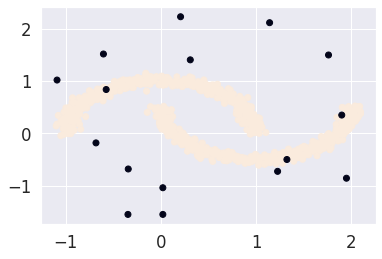

In [6]:
plt.scatter(*X_train.T, c=y_train)

### Problem statement

Anomaly detection problem statement: train function $\hat{f}:\mathcal{X}\to \mathbb{R}$ on dataset $\mathcal{S}$, such that

  * $\hat{f}(x) \leq 0$, where $x$ -- **normal** observation, $\hat{f}(x) > 0$ -- **anomal**;

  * with low rate of **misses**: $\hat{f}(x) \leq 0$ for **anomal** $x$;

  * and low rate of **false alarms**: $\hat{f}(x) > 0$ for **normal** $x$.

The exact representation $\mathcal{S}$ could vary depending on problem:


**...sometimes we have labels**

  * i.e. $\mathcal{S} = (x_i, y_i)_{i=1}^m$ where $y_i\in \{\pm 1\}$ are __anomaly__ labels;
  * <span style="color: red">**BUT** </span> normal observations are dominant class:
  $$
    \overbrace{\lvert i\colon y_i = +1 \rvert}^{n_+}
        \ll \overbrace{\lvert i\colon y_i = -1 \rvert}^{n_-}
    \,. $$


$\color{red}{\Rightarrow}$ **imbalanced classification**

**...sometimes we don't have labels

  * $\mathcal{S} = (x_i)_{i=1}^m$ -- **no labels!**;

  * predict $\alpha \in (0, 1)$ -- level of anomalies.


$\color{red}{\Rightarrow}$ **outlier detection**

### Metrics

We are going to use accuracy, precision, recall and $f1$-score to assess the quality of the model:

* **accuracy**

![pr_rc](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)


$$
    F_\beta
        = (1 + \beta^2)
            \frac{\text{Precision} \cdot \text{Recall}}
                 {\beta^2 \, \text{Precision} + \text{Recall}}
        = \frac{\beta + \beta^{-1}}{\beta\frac{1}{\text{Recall}} + \beta^{-1}\frac{1}{\text{Precision}}}
\,. $$

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

<br>

## 1.2 VAE implementation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1.2.1 Encoder

In [9]:
class Encoder(nn.Module):
    '''
    (Probabilistic) Encoder
    Inference Model
    '''
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            # nn.Linear(32, 32),
            # nn.Tanh(),
            # nn.Linear(32, 32),
            # nn.Tanh(),
        )
        self.linear_mean = nn.Linear(32, 8)
        self.linear_log_variance = nn.Linear(32, 8)

    def reparameterize(self, mean, log_variance):
        """
        Sample from normal distribution with reparameterization trick
        I.e. z = \mu + N(0, 1) \sigma
        """
        # YOUR CODE HERE
        std = torch.exp(0.5*log_variance)
        eps = torch.randn_like(std)
        z = mean + std * eps
        return z

    def forward(self, x):
        h = self.fc1(x)
        mean = self.linear_mean(h)
        log_variance = self.linear_log_variance(h)
        z = self.reparameterize(mean, log_variance)
        return z, mean, log_variance

In [10]:
encoder_test = Encoder()

mu = torch.tensor(1000 * [0.])
sigma = torch.tensor(1000 * [0.])

assert encoder_test.reparameterize(mu, sigma).shape == (1000, )
assert encoder_test.reparameterize(mu, sigma).mean().abs() < 7. / np.sqrt(1000.)

mu = torch.tensor(10000 * [5.])
sigma = torch.tensor(10000 * [1.])

assert encoder_test.reparameterize(mu, sigma).shape == (10000, )
assert (encoder_test.reparameterize(mu, sigma).mean().abs() - 5.) < np.exp(0.5) * 7. / np.sqrt(10000.)

### 1.2.2 Decoder

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(8, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            # nn.Linear(32, 32),
            # nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, z):
        x_recon = self.fc1(z)
        return x_recon

### 1.2.3 VAE

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, log_variance = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mean, log_variance

### 1.2.4 Reconstruction loss

In [13]:
def reconstruction_error(x_recon, x, reduction='sum'):
    """
    MSE loss between x_recon and x
    """
    # YOUR CODE HERE
    reco_error = F.mse_loss(x_recon, x, reduction=reduction)
    return reco_error

In [14]:
np_testing.assert_approx_equal(
    reconstruction_error(
        torch.tensor([1., 2., 3.]),
        torch.tensor([1., 2., 3.])
    ),
    0.
)

np_testing.assert_approx_equal(
    reconstruction_error(
        torch.tensor([1., 2., 3.]),
        torch.tensor([1., 10., 3.])
    ),
    64.
)

np_testing.assert_approx_equal(
    reconstruction_error(
        torch.tensor([1., 2., 3.]),
        torch.tensor([-1., 10., 3.1])
    ),
    68.01000213623047
)

np_testing.assert_approx_equal(
    reconstruction_error(
        torch.tensor([1., 2., 3.]),
        torch.tensor([-1., 10., 3.1]), 
        reduction='mean'
    ),
    22.670000076293945
)

### 1.2.5 KL divergence

In [15]:
# see Appendix B from VAE paper:
# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
# https://arxiv.org/abs/1312.6114
# 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
def kl_divergence(mean, log_variance):
    """
    KL divergence between normal distribution with mean and log_variance and N(0, 1)
    """
    # YOUR CODE HERE
    variance = torch.exp(log_variance)
    kl = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    return kl

In [16]:
np_testing.assert_approx_equal(
    kl_divergence(torch.tensor(0.), torch.tensor(0.)).item(),
    0.
)

np_testing.assert_approx_equal(
    kl_divergence(torch.tensor(1.), torch.tensor(0.)).item(),
    0.5
)

np_testing.assert_approx_equal(
    kl_divergence(torch.tensor(2.), torch.tensor(np.log(5) * 2)).item(),
    12.390563011169434
)

np_testing.assert_approx_equal(
    kl_divergence(torch.tensor(-3.), torch.tensor(-5.)).item(),
    6.503368854522705
)

### 1.2.6 Training and testing functions

In [17]:
def train(model, data_loader, optimizer, device, reg_weight=1.):
    model.train()
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, log_variance = model(data)
        reco_error = reconstruction_error(recon_batch, data)
        kld = kl_divergence(mean, log_variance)
        loss = reco_error + kld * reg_weight
        loss.backward()
        optimizer.step()

In [18]:
def test(model, data_loader, device):
    model.eval()
    # accumulated loss
    accum_reco_error = 0
    accum_kld = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mean, log_variance = model(data)

            reco_error = reconstruction_error(recon_batch, data)
            kld = kl_divergence(mean, log_variance)

            accum_reco_error += reco_error.item()
            accum_kld += kld.item()

    num_examples = len(data_loader.dataset)

    average_reco_error = accum_reco_error / num_examples
    average_kld = accum_kld / num_examples
    average_loss = average_reco_error + average_kld
    return average_loss, (average_reco_error, average_kld)

### 1.2.7 RUN!

In [19]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])
device = torch.device("cuda:{}".format(get_free_gpu()))
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
epochs = 300
batch_size = 256
train_loader = DataLoader(torch.tensor(X_train).float(), batch_size=batch_size)
valid_loader = DataLoader(torch.tensor(X_val).float(), batch_size=batch_size)

In [21]:
for epoch in tqdm.tqdm_notebook(range(1, epochs + 1)):
    train(model, train_loader, optimizer, device, reg_weight=0.01)

    train_loss, (train_reco_error, train_kld) = test(model, train_loader, device)
    valid_loss, (valid_reco_error, valid_kld) = test(model, valid_loader, device)
    if epoch % 50 == 0:
        print()
        print(f'[Epoch: {epoch}/{epochs}] Training Loss: {train_loss:.4f} = Reconstruction Error ({train_reco_error:.4f}) + KL Divergence({train_kld:.4f})')
        print(f'[Epoch: {epoch}/{epochs}] Validation Loss: {valid_loss:.4f} = Reconstruction Error ({valid_reco_error:.4f}) + KL Divergence({valid_kld:.4f})')


[Epoch: 50/300] Training Loss: 6.3819 = Reconstruction Error (0.0408) + KL Divergence(6.3411)
[Epoch: 50/300] Validation Loss: 7.6337 = Reconstruction Error (0.1873) + KL Divergence(7.4464)



[Epoch: 100/300] Training Loss: 4.6476 = Reconstruction Error (0.0188) + KL Divergence(4.6288)
[Epoch: 100/300] Validation Loss: 5.5052 = Reconstruction Error (0.0794) + KL Divergence(5.4258)



[Epoch: 150/300] Training Loss: 4.4242 = Reconstruction Error (0.0148) + KL Divergence(4.4095)
[Epoch: 150/300] Validation Loss: 5.1559 = Reconstruction Error (0.0536) + KL Divergence(5.1023)



[Epoch: 200/300] Training Loss: 4.3616 = Reconstruction Error (0.0123) + KL Divergence(4.3493)
[Epoch: 200/300] Validation Loss: 5.1568 = Reconstruction Error (0.0429) + KL Divergence(5.1139)



[Epoch: 250/300] Training Loss: 4.3281 = Reconstruction Error (0.0142) + KL Divergence(4.3139)
[Epoch: 250/300] Validation Loss: 5.2037 = Reconstruction Error (0.0368) + KL Divergence(5.1669)



[Epoch: 300/300] Training Loss: 4.3494 = Reconstruction Error (0.0112) + KL Divergence(4.3382)
[Epoch: 300/300] Validation Loss: 5.3116 = Reconstruction Error (0.0307) + KL Divergence(5.2809)



In [22]:
for epoch in tqdm.tqdm_notebook(range(1, epochs + 1)):
    train(model, train_loader, optimizer, device, reg_weight=0.05)

    train_loss, (train_reco_error, train_kld) = test(model, train_loader, device)
    valid_loss, (valid_reco_error, valid_kld) = test(model, valid_loader, device)
    if epoch % 50 == 0:
        print()
        print(f'[Epoch: {epoch}/{epochs}] Training Loss: {train_loss:.4f} = Reconstruction Error ({train_reco_error:.4f}) + KL Divergence({train_kld:.4f})')
        print(f'[Epoch: {epoch}/{epochs}] Validation Loss: {valid_loss:.4f} = Reconstruction Error ({valid_reco_error:.4f}) + KL Divergence({valid_kld:.4f})')


[Epoch: 50/300] Training Loss: 2.7478 = Reconstruction Error (0.0530) + KL Divergence(2.6948)
[Epoch: 50/300] Validation Loss: 3.9071 = Reconstruction Error (0.0994) + KL Divergence(3.8078)



[Epoch: 100/300] Training Loss: 2.6935 = Reconstruction Error (0.0496) + KL Divergence(2.6439)
[Epoch: 100/300] Validation Loss: 3.8546 = Reconstruction Error (0.1028) + KL Divergence(3.7518)



[Epoch: 150/300] Training Loss: 2.7223 = Reconstruction Error (0.0504) + KL Divergence(2.6719)
[Epoch: 150/300] Validation Loss: 3.8767 = Reconstruction Error (0.1059) + KL Divergence(3.7709)



[Epoch: 200/300] Training Loss: 2.6263 = Reconstruction Error (0.0528) + KL Divergence(2.5735)
[Epoch: 200/300] Validation Loss: 3.8010 = Reconstruction Error (0.1105) + KL Divergence(3.6905)



[Epoch: 250/300] Training Loss: 2.7091 = Reconstruction Error (0.0482) + KL Divergence(2.6609)
[Epoch: 250/300] Validation Loss: 3.9241 = Reconstruction Error (0.1080) + KL Divergence(3.8162)



[Epoch: 300/300] Training Loss: 2.6784 = Reconstruction Error (0.0455) + KL Divergence(2.6329)
[Epoch: 300/300] Validation Loss: 3.8758 = Reconstruction Error (0.1129) + KL Divergence(3.7629)



### Let's try to sample from VAE

In [23]:
decoder = model.decoder

In [24]:
with torch.no_grad():
    decoder.eval()
    z = torch.randn(512, 8).to(device) * 2
    x_recon = decoder(z).cpu()

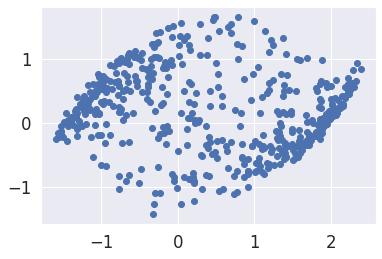

In [25]:
plt.scatter(*x_recon.t())

## 1.3 Calculate anomaly score

Anomaly score usually is defined as reconstruction error.

In [26]:
class AnomalyVAE:
    def __init__(self, model, device, threshold=0.):
        self._model = model
        self._threshold = threshold
        self._device = device

    def decision_function(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(self._device)
        if isinstance(x, torch.Tensor):
            x = x.to(self._device)
        x_reco, _, _ = self._model(x)
        score = -reconstruction_error(x_reco, x, reduction='none').mean(dim=1).cpu().detach().numpy()
        return score

    def predict(self, x):
        return (self.decision_function(x) < -self._threshold) * 1.

    def set_threshold(self, threshold):
        self._threshold = threshold

In [27]:
anomaly_vae = AnomalyVAE(model, device, threshold=0.3)

In [28]:
_, _, X_test, y_test = create_dataset_moons(
    train_size_pos=1, train_size_neg=1, test_size=1024
)

In [29]:
reco_error = -anomaly_vae.decision_function(X_test)

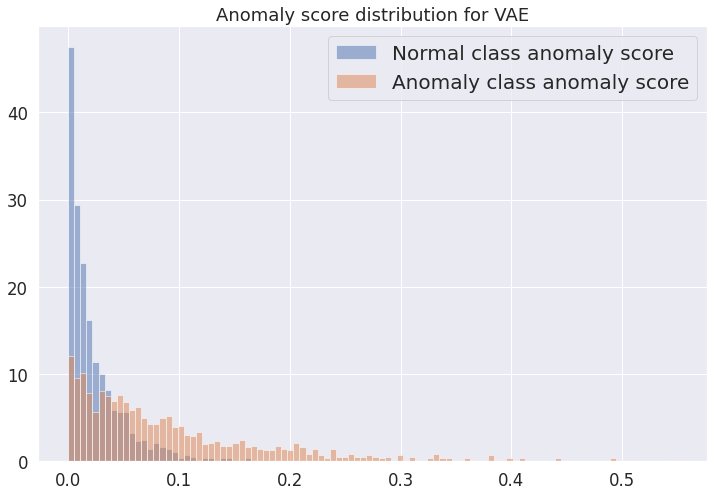

In [30]:
min_error = np.min(reco_error)
max_error = np.max(reco_error)

hist_kwargs  = {
    'alpha': 0.5,
    'range': (min_error, max_error),
    'bins': 100,
    'density': True
}

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Anomaly score distribution for VAE")
_ = ax.hist(reco_error[y_test == 1], label='Normal class anomaly score', **hist_kwargs)
_ = ax.hist(reco_error[y_test == 0], label='Anomaly class anomaly score', **hist_kwargs)
ax.legend(fontsize=20)

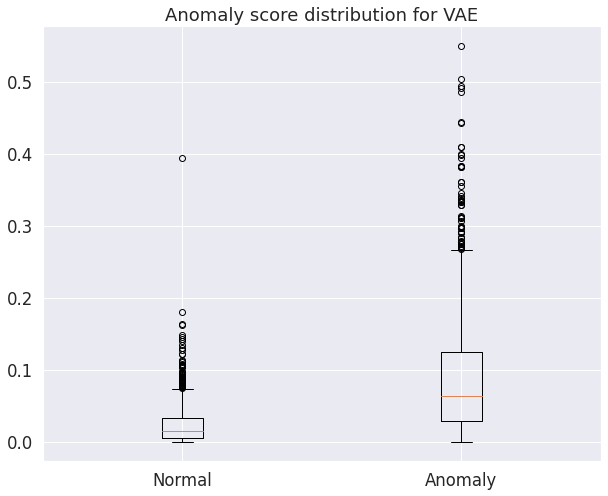

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 8))

ax.set_title("Anomaly score distribution for VAE")

ax.boxplot([reco_error[y_test == 1], reco_error[y_test == 0]])
ax.set_xticklabels(['Normal', 'Anomaly'])

plt.show()

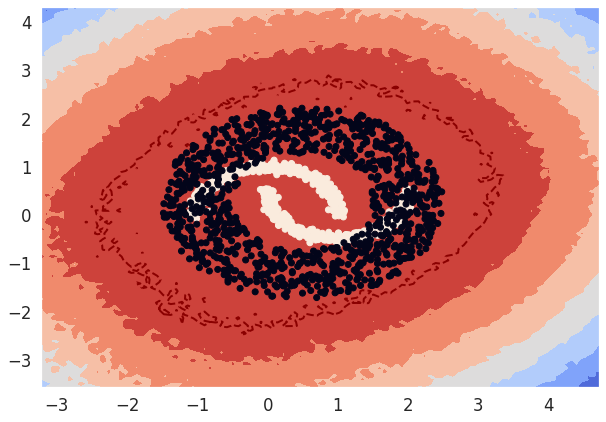

In [32]:
plot_level_lines(anomaly_vae, X_test, y_test)

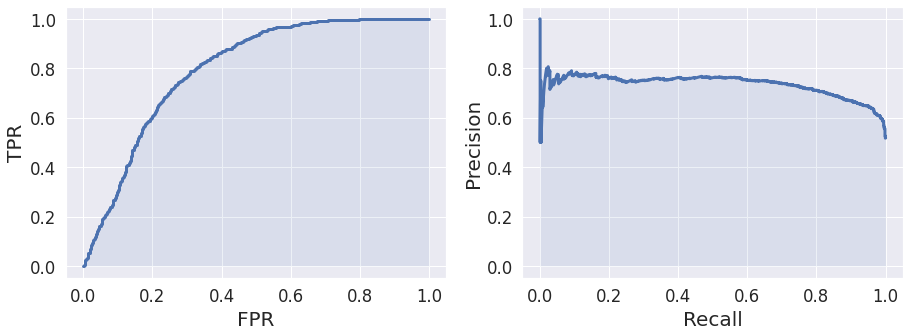

              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65      1024
         1.0       0.00      0.00      0.00      1024

    accuracy                           0.48      2048
   macro avg       0.25      0.48      0.32      2048
weighted avg       0.25      0.48      0.32      2048



In [33]:
predictions_vae = anomaly_vae.decision_function(X_test)
labels_vae = anomaly_vae.predict(X_test)


plot_results(y_test, predictions_vae)

metrics_elliptic = classification_report(y_test, labels_vae, output_dict=True)
print(classification_report(y_test, labels_vae))